In [1]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

Example of Kalman Filter

Text(0.5, 0, 'Time [s]')

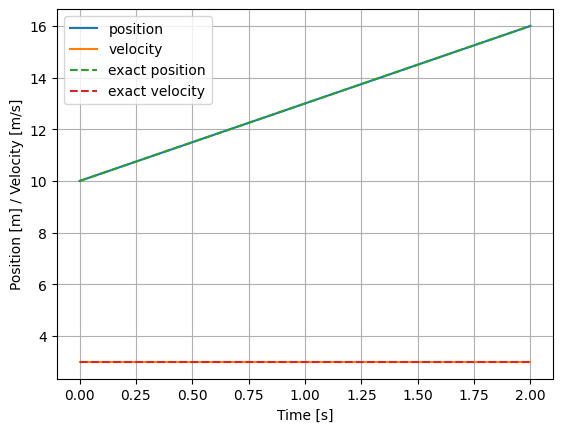

In [18]:
T = 2
Nt = 1000
dt = T/Nt
u = np.ones((T,2))*0
x0 = 10
v0 = 3
g = 0

def get_sensor_reading():
    return f.x


# Create the filter object
f = KalmanFilter (dim_x=2, dim_z=2)

# Assign the initial x array
f.x = np.array([x0, v0])    #  (position, velocity)

# Define the transition matrix (this will be our NN)
f.F = np.array([[1, dt],
                [0., 1]])

# Define the measurament function
f.H = np.array([[1, 0], 
                [0, 1]])

# Define the covariance matrix
f.P = np.array([[1000,  0.],
                [0.,  1000] ])

# Assign the measurament noise
f.R = np.array([[5, 0], 
                [0, 5]])

# Assign the process noise
f.Q = Q_discrete_white_noise(dim=2, dt=0.1, var=0.13)
#f.Q = np.array([[2, 0], [0, 2]])

# Predict/Update loop
tt=np.arange(0,T+dt,dt)
x_hat = np.zeros((Nt+1,2))
x_hat[0,:]=f.x
for i in range(tt.shape[0]-1):
    f.predict()
    x_hat[i+1,:] = f.x
    z = get_sensor_reading()
    f.update(z)

x_ex = np.zeros((Nt+1,2))
for i,t in enumerate(tt):
    x_ex[i,0] = x0 + v0*t + 0.5*g*t**2
    x_ex[i,1] = v0 + g*t

plt.figure()
plt.grid(True)
plt.plot(tt,x_hat[:,0], label='position')
plt.plot(tt,x_hat[:,1], label='velocity')
plt.plot(tt,x_ex[:,0], label='exact position', linestyle='--')
plt.plot(tt,x_ex[:,1], label='exact velocity', linestyle='--')
plt.legend()
plt.ylabel('Position [m] / Velocity [m/s]')
plt.xlabel('Time [s]')


Example of Ensamble Kalman Filter applied on position and velocity

Text(0.5, 0, 'Time [s]')

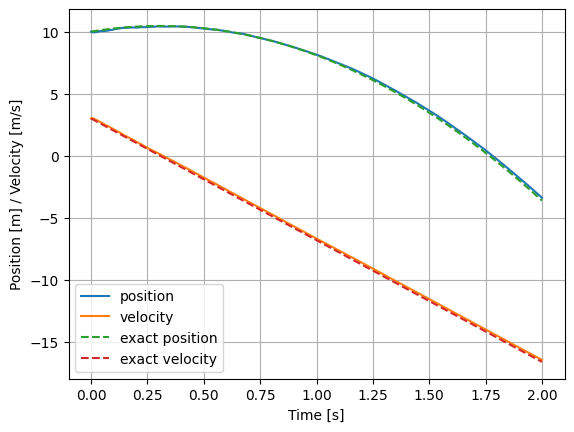

In [14]:
from filterpy.kalman import EnsembleKalmanFilter as EnKF

T = 2
Nt = 1000
dt = T/Nt
u = np.ones((T,2))*0
x0 = 10
v0 = 3
g = -9.81

def get_sensor_reading():
    return f.x

# Define the measurament function (this will be our NN)
def hx(x):
   return np.array([x[0], x[1]])

# Define the transition matrix
F = np.array([[1., dt],
              [0., 1.]])
def fx(x, dt):
    return np.dot(F, x) + (0.5*g*dt**2)*np.array([1, 0]) + g*dt*np.array([0, 1])

# Assign the initial x array
x = np.array([x0, v0])

# Define the covariance matrix
P = np.eye(2)

# Create the EnKF model
f = EnKF(x=x, P=P, dim_z=2, dt=dt, N=100,
         hx=hx, fx=fx)

# Assign the measurament noise
# f.R = np.eye(2)
f.R = np.array([[1,   0],
               [0,   1]])

# Assign the process noise
f.Q = Q_discrete_white_noise(dim=2, dt=dt, var=.01)

# Predict/Update loop
tt=np.arange(0,T+dt,dt)
x_hat = np.zeros((Nt+1,2))
x_hat[0,:]=f.x
for i in range(tt.shape[0]-1):
    z = get_sensor_reading()
    f.predict()
    x_hat[i+1,:] = f.x
    f.update(z)

x_ex = np.zeros((Nt+1,2))
for i,t in enumerate(tt):
    x_ex[i,0] = x0 + v0*t + 0.5*g*t**2
    x_ex[i,1] = v0 + g*t

plt.figure()
plt.grid(True)
plt.plot(tt,x_hat[:,0], label='position')
plt.plot(tt,x_hat[:,1], label='velocity')
plt.plot(tt,x_ex[:,0], label='exact position', linestyle='--')
plt.plot(tt,x_ex[:,1], label='exact velocity', linestyle='--')
plt.legend()
plt.ylabel('Position [m] / Velocity [m/s]')
plt.xlabel('Time [s]')

Example of Ensamble Kalman Filter applied on prey and predator

Text(0.5, 0, 'Prey [-]')

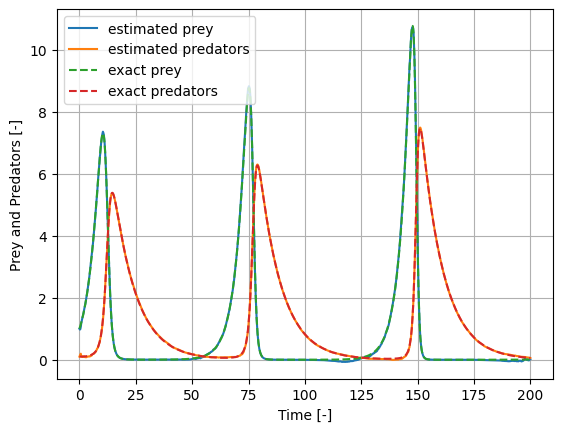

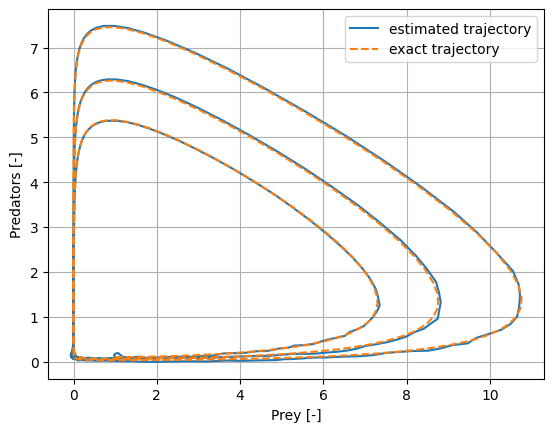

In [6]:
from filterpy.kalman import EnsembleKalmanFilter as EnKF

T = 200
Nt = 1000
dt = T/Nt
x0 = 1
y0 = 0.1
rho = 0
alpha = 0.25
beta = 0.2
gamma = 0.1
delta = 0.1

# Define the measurament function
def hx(x):
   return np.array([x[0], x[1]])

# Define the transition function
def fx(x, dt):
    F = np.array([[1 + alpha*dt - beta*dt*x[1] -rho*dt*x[0],                             0],
                  [0,                                           1-gamma*dt + delta*dt*x[0]]])
    return np.dot(F, x)

# Assign the initial x array
x = np.array([x0, y0])

# Define the covariance matrix
P = np.eye(2)

# Create the EnKF model
f = EnKF(x=x, P=P, dim_z=2, dt=dt, N=100,
         hx=hx, fx=fx)

# Assign the measurament noise
f.R = np.eye(2)

# Assign the process noise
f.Q = Q_discrete_white_noise(dim=2, dt=dt, var=.01)

# Exact solution
tt=np.arange(0,T+dt,dt)
x_ex = np.zeros((Nt+1,2))
for i,t in enumerate(tt):
    if i==0:
        x_ex[i,:] = np.array([x0,y0])
    else:
        x_ex[i,0] = x_ex[i-1,0] + dt*x_ex[i-1,0]*(alpha-beta*x_ex[i-1,1]-rho*x_ex[i-1,0])
        x_ex[i,1] = x_ex[i-1,1] + dt*x_ex[i-1,1]*(-gamma+delta*x_ex[i-1,0])


def get_sensor_reading(i):
    return x_ex[i,:]

# Predict/Update loop
tt=np.arange(0,T+dt,dt)
x_hat = np.zeros((Nt+1,2))
x_hat[0,:]=f.x
for i in range(tt.shape[0]-1):
    f.predict()
    x_hat[i+1,:] = f.x
    z = get_sensor_reading(i+1)
    f.update(z)

x_ex = np.zeros((Nt+1,2))
for i,t in enumerate(tt):
    if i==0:
        x_ex[i,:] = np.array([x0,y0])
    else:
        x_ex[i,0] = x_ex[i-1,0] + dt*x_ex[i-1,0]*(alpha-beta*x_ex[i-1,1]-rho*x_ex[i-1,0])
        x_ex[i,1] = x_ex[i-1,1] + dt*x_ex[i-1,1]*(-gamma+delta*x_ex[i-1,0])

plt.figure()
plt.grid(True)
plt.plot(tt,x_hat[:,0], label='estimated prey')
plt.plot(tt,x_hat[:,1], label='estimated predators')
plt.plot(tt,x_ex[:,0], label='exact prey', linestyle='--')
plt.plot(tt,x_ex[:,1], label='exact predators', linestyle='--')
plt.legend()
plt.ylabel('Prey and Predators [-]')
plt.xlabel('Time [-]')

plt.figure()
plt.grid(True)
plt.plot(x_hat[:,0],x_hat[:,1], label='estimated trajectory')
plt.plot(x_ex[:,0],x_ex[:,1], label='exact trajectory', linestyle='--')
plt.legend()
plt.ylabel('Predators [-]')
plt.xlabel('Prey [-]')

#np.save('../data/prey_predator_1.npy',x_ex)

Example of Ensamble Kalman Filter applied on prey and predator with input data

Text(0.5, 0, 'Prey [-]')

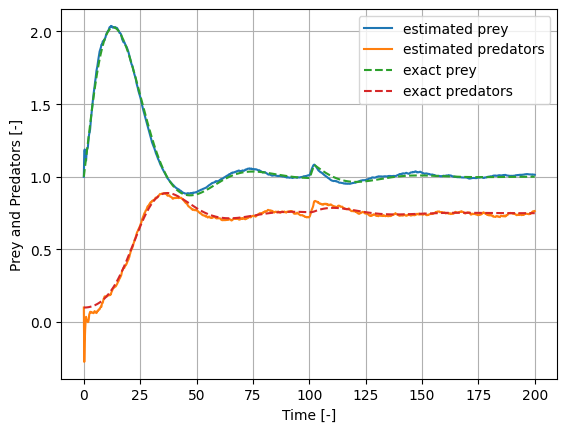

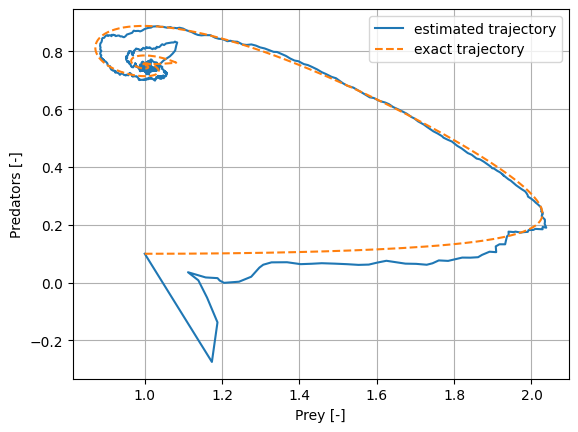

In [26]:
from filterpy.kalman import EnsembleKalmanFilter as EnKF

T = 200
Nt = 1000
dt = T/Nt
x0 = 1
y0 = 0.1
rho = 0.1
alpha = 0.25
beta = 0.2
gamma = 0.1
delta = 0.1

# Define the input of prey and predators
u = np.zeros((Nt,))
v = np.zeros((Nt,))
for i in range(Nt):
    if i>Nt/2 and i<Nt/2+11:
        u[i] = 0.05

# Define the measurament function (this will be our NN)
def hx(x):
   return np.array([x[0], x[1]])

# Define the transition function
def fx(x, dt):
    F = np.array([[1 + alpha*dt - beta*dt*x[1] -rho*dt*x[0],                             0],
                  [0,                                           1-gamma*dt + delta*dt*x[0]]])
    B = np.array([dt, dt])
    d = np.array([u[i], v[i]])
    return np.dot(F, x) + np.dot(B, d)

# Assign the initial x array
x = np.array([x0, y0])

# Define the covariance matrix
P = np.eye(2)

# Create the EnKF model
f = EnKF(x=x, P=P, dim_z=2, dt=dt, N=100,
         hx=hx, fx=fx)

# Assign the measurament noise
f.R = np.eye(2)

# Assign the process noise
f.Q = Q_discrete_white_noise(dim=2, dt=dt, var=.01)

# Exact solution
tt=np.arange(0,T+dt,dt)
x_ex = np.zeros((Nt+1,2))
for i,t in enumerate(tt):
    if i==0:
        x_ex[i,:] = np.array([x0,y0])
    else:
        x_ex[i,0] = x_ex[i-1,0] + dt*x_ex[i-1,0]*(alpha-beta*x_ex[i-1,1]-rho*x_ex[i-1,0]) + u[i-1]*dt
        x_ex[i,1] = x_ex[i-1,1] + dt*x_ex[i-1,1]*(-gamma+delta*x_ex[i-1,0]) + v[i-1]*dt

def get_sensor_reading(i):
    return x_ex[i,:]

# Predict/Update loop
tt=np.arange(0,T+dt,dt)
x_hat = np.zeros((Nt+1,2))
x_hat[0,:]=f.x
for i in range(tt.shape[0]-1):
    f.predict()
    x_hat[i+1,:] = f.x
    z = get_sensor_reading(i+1)
    f.update(z)

plt.figure()
plt.grid(True)
plt.plot(tt,x_hat[:,0], label='estimated prey')
plt.plot(tt,x_hat[:,1], label='estimated predators')
plt.plot(tt,x_ex[:,0], label='exact prey', linestyle='--')
plt.plot(tt,x_ex[:,1], label='exact predators', linestyle='--')
plt.legend()
plt.ylabel('Prey and Predators [-]')
plt.xlabel('Time [-]')

plt.figure()
plt.grid(True)
plt.plot(x_hat[:,0],x_hat[:,1], label='estimated trajectory')
plt.plot(x_ex[:,0],x_ex[:,1], label='exact trajectory', linestyle='--')
plt.legend()
plt.ylabel('Predators [-]')
plt.xlabel('Prey [-]')